## 6.1 GAN을 활용한 이상 이미지 탐지 메커니즘
### 6.1.2 GAN을 활용한 이상 이미지 검출의 필요성
* AnoGAN기술
    * **정상 이미지만으로만 딥러닝을 실시하여 이상 이미지를 검출**하는 알고리즘을 구축하기 위해 사용
    * 정답 이미지를 생성하는 GAN모델을 구축하고 판정할 테스트 이미지를 Discriminator에 투입하여 테스트 이미지가 지도데이터(정상데이터)인지 가짜 이미지인지 판정
    
    
### 6.1.3 AnoGAN 개요
* 일반적인 GAN의 개요
    * 생성 노이즈 z를 생성기 G에 입력하여 이미지를 생성한 후 생성한 이미지가 지도 데이터인지 생성 데이터인지 식별기 D로 판정
* AnoGAN 개요
    * 우선 GAN모델 학습
    * 학습시킨 G와 D로 이상 탐지 실시
    * 생성 노이즈 z를 생성하여 G에 입력
        * 생성노이즈: 테스트 이미지와 가장 비슷한 이미지를 생성할 수 있도록 하는 변수
        * 정상 이미지라면 G에서 테스트 데이터와 비슷한 이미지가 생성됨
* AnoGAN에서 G는 정상 이미지만 생성할 수 있음!

In [1]:
import os
import urllib.request
import zipfile
import tarfile

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np

In [2]:
# data 폴더가 없으면 작성한다
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [3]:
import sklearn
print(sklearn.__version__)

# AWS의 AMI에서 sklern의 version이 0.20보다 낮은 경우에는 버전을 업데이트합니다
# pip install -U scikit-learn

0.22.1


In [6]:
# MNIST의 필기체 숫자 화상을 다운로드하여 읽습니다
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, data_home="./data/")  # data_home으로 저장 위치를 지정합니다

In [7]:
# 데이터 꺼내기
X = mnist.data
y = mnist.target


이 화상 데이터의 라벨은 5입니다


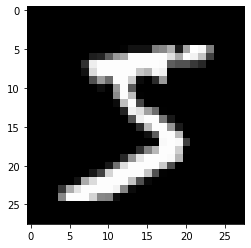

In [8]:
# MNIST의 데이터 첫 번째를 시각화
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("이 화상 데이터의 라벨은 {}입니다".format(y[0]))

In [9]:
# "data" 폴더의 아래에 "img_78" 폴더를 작성한다
data_dir_path = "./data/img_78/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

In [10]:
# MNIST에서 숫자7, 8의 화상만 "img_78" 폴더에 화상으로 저장해 나간다
count7=0
count8=0
max_num=200  # 화상은 200장씩 작성한다

for i in range(len(X)):
    
    # 화상7 작성
    if (y[i] is "7") and (count7<max_num):
        file_path="./data/img_78/img_7_"+str(count7)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 화상을 28×28의 형태로 변경
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 화상을 PIL으로
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64로 확대
        pil_img_f.save(file_path)  # 저장
        count7+=1 
    
    # 화상8 작성
    if (y[i] is "8") and (count8<max_num):
        file_path="./data/img_78/img_8_"+str(count8)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 화상을 28×28의 형태로 변경
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 화상을 PIL으로
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64로 확대
        pil_img_f.save(file_path)  # 저장
        count8+=1
        
    # 7과 8을 200장씩 작성했다면 break
    if (count7>=max_num) and (count8>=max_num):
        break



In [11]:
# "data" 폴더의 아래에 "test" 폴더를 작성한다
data_dir_path = "./data/test/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

In [12]:
# 위에서 7,8의 화상 작성에 사용한 index의 최종값
i_start = i+1
print(i_start)

2244


In [13]:
# MNIST에서 숫자2, 7, 8의 화상만 "test" 폴더에 화상으로 저장해 나간다
count2=0
count7=0
count8=0
max_num=5  # 화상은 5장씩 작성한다

for i in range(i_start,len(X)):  # i_start에서 시작
    
    # 화상2 작성
    if (y[i] is "2") and (count2<max_num):
        file_path="./data/test/img_2_"+str(count2)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 화상을 28×28의 형태로 변경
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 화상을 PIL으로
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64로 확대
        pil_img_f.save(file_path)  # 저장
        count2+=1
    
    # 화상7 작성
    if (y[i] is "7") and (count7<max_num):
        file_path="./data/test/img_7_"+str(count7)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 화상을 28×28의 형태로 변경
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 화상을 PIL으로
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64로 확대
        pil_img_f.save(file_path)  # 저장
        count7+=1 
    
    # 화상8 작성
    if (y[i] is "8") and (count8<max_num):
        file_path="./data/test/img_8_"+str(count8)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 화상을 28×28의 형태로 변경
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 화상을 PIL으로
        pil_img_f = pil_img_f.resize((64, 64), Image.BICUBIC)  # 64×64로 확대
        pil_img_f.save(file_path)  # 저장
        count8+=1 

In [14]:
# "data" 폴더의 아래에 "img_78_28size" 폴더를 작성한다
data_dir_path = "./data/img_78_28size/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

In [15]:
# MNIST에서 숫자7, 8의 화상만 "img_78_28size" 폴더에 화상으로 저장해 나간다
count7=0
count8=0
max_num=200  # 화상은 200장씩 작성한다

for i in range(len(X)):
    
    # 화상7 작성
    if (y[i] is "7") and (count7<max_num):
        file_path="./data/img_78_28size/img_7_"+str(count7)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 화상을 28×28의 형태로 변경
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 화상을 PIL으로
        pil_img_f.save(file_path)  # 저장
        count7+=1 
    
    # 화상8 작성
    if (y[i] is "8") and (count8<max_num):
        file_path="./data/img_78_28size/img_8_"+str(count8)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 화상을 28×28의 형태로 변경
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 화상을 PIL으로
        pil_img_f.save(file_path)  # 저장
        count8+=1
    
    if (count7>=max_num) and (count8>=max_num):
        break



In [16]:
# "data" 폴더의 아래에 "test_28size" 폴더를 작성한다
data_dir_path = "./data/test_28size/"
if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

# 위에서 7,8의 화상 작성에 사용한 index의 최종값
i_start = i+1
print(i_start)

2244


In [17]:
# MNIST에서 숫자2, 7, 8의 화상만 "test_28size" 폴더에 화상으로 저장해 나간다
count2=0
count7=0
count8=0
max_num=5  # 화상은 5장씩 작성한다

for i in range(i_start,len(X)):  # i_start에서 시작
    
    # 화상2 작성
    if (y[i] is "2") and (count2<max_num):
        file_path="./data/test_28size/img_2_"+str(count2)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 화상을 28×28의 형태로 변경
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 화상을 PIL으로
        pil_img_f.save(file_path)  # 저장
        count2+=1 
    
    # 화상7 작성
    if (y[i] is "7") and (count7<max_num):
        file_path="./data/test_28size/img_7_"+str(count7)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 화상을 28×28의 형태로 변경
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 화상을 PIL으로
        pil_img_f.save(file_path)  # 저장
        count7+=1 
    
    # 화상8 작성
    if (y[i] is "8") and (count8<max_num):
        file_path="./data/test_28size/img_8_"+str(count8)+".jpg"
        im_f=(X[i].reshape(28, 28))  # 화상을 28×28의 형태로 변경
        pil_img_f = Image.fromarray(im_f.astype(np.uint8))  # 화상을 PIL으로
        pil_img_f.save(file_path)  # 저장
        count8+=1 



## 6.2 AnoGAN 구현 및 이상 탐지 실시
### 6.2.1 DCGAN 학습
* AnoGAN학습
    * 임의의 GAN을 사용하여 AnoGAN을 구현할 수 있음
    
    * 일반적인 DCGAN을 지도 데이터에서 학습
        *  생성기의 모델, 식별기의 모델, 지도 데이터의 데이터로더를 준비한 후 학습 실행
    * **식별기의 출력(0: 생성 데이터, 1: 지도 데이터)에서 특징량도 출력**
        * 특징량: 생성노이즈 z를 구할 떄 사용

In [18]:
# 패키지 import
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [19]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


In [20]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8,
                               kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 주의: 흑백 화상이므로, 출력 채널은 하나 뿐임

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out


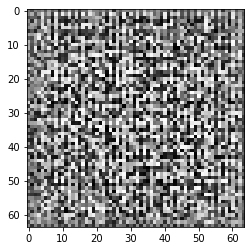

In [21]:
# 동작 확인
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 압력 난수
input_z = torch.randn(1, 20)

# 텐서 사이즈를 (1, 20, 1, 1)로 변형
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 가짜 화상을 출력
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


In [22]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 주의: 흑백 화상이므로 입력 채널은 하나 뿐임

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        feature = out  # 최후에 채널을 하나로 집약
        feature = feature.view(feature.size()[0], -1)  # 2차원으로 변환

        out = self.last(out)

        return out, feature


In [48]:
# 동작 확인
D = Discriminator(z_dim=20, image_size=64)

# 가짜 화상 생성
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)

# 가짜 화상을 D에 입력
d_out = D(fake_images)

# 출력 d_out에 Sigmoid를 곱해 0에서 1로 변환
# 0: 생성 데이터, 1: 지도 데이터
print(nn.Sigmoid()(d_out[0]))

# feature
print(d_out[1].shape)

tensor([[[[0.4935]]]], grad_fn=<SigmoidBackward>)
torch.Size([1, 8192])


### 6.2.2 AnoGAN의 생성 난수 z를 구하는 방법
* 처음에는 적당한 난수로
* 생성된 이미지와 테스트 이미지의 채널별 픽셀 수준의 차이를 계산한 후 픽셀 차이의 절댓값 합을 구하여 손실 값을 계산
    * 채널별 픽셀 수준의 차이를 줄이기 위해 z의 미분 값을 구함


* `require_grad = True`: 역전파 중에 이 Tensor들에 대한 변화도를 계산하라는 의미. 계산한 변화도는 Tensor 내에 저장됨
* `torch.optim`: 파이토치에서는 optimizer를 지정하는데 사용함
* `Adam`: RMSProp과 모멘텀을 사용해서 진행방향과 learning rate 모두를 적절하게 유지하면서 가중치를 업데이트할 수 있도록 고안된 방법


* 최적의 z값 구하기
    * z를 G에 입력하여 이미지 생성 → z의 미분 값 계산 → `optimizer.step()`: z값 갱신 → ...

In [50]:
z = torch.rand(5, 20).to(device)
z = z.view(z.size(0), z.size(1), 1, 1)

# 변수 z를 미분할 수 있도록 requires_grad를 True로 설정
z.require_grad = True

# 변수 z를 갱신할 수 있도록 z의 최적화 함수를 구한다.
z_optimizer = torch.optim.Adam([z], lr = 1e-3)

### 6.2.4 AnoGAN 학습 구현과 이상 탐지 실시
* 데이터로더
    * 정상 이미지: 7, 8
    * 이상 이미지: 2

In [24]:
def make_datapath_list():
    """학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트를 작성한다. """

    train_img_list = list()  # 화상 파일 경로를 저장

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

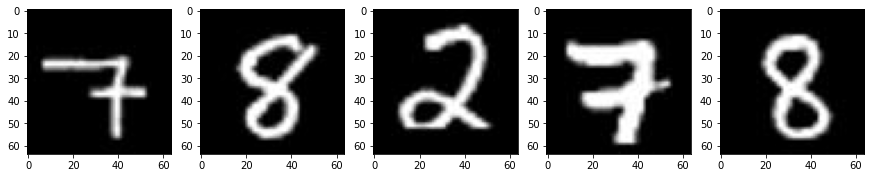

In [64]:
# 테스트 데이터 확인
batch_iterator = iter(test_dataloader) # 반복자로 변환
images = next(batch_iterator)

# 첫 번째 미니 배치를 꺼낸다.
fig = plt.figure(figsize = (15 ,6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')
    
# 출력결과: 이상 탐지를 실행할 테스트 이미지

* 노이즈를 구하기 위한 학습
    * 테스트 이미지와 가장 비슷한 이미지를 생성할 수 있도록 설정해야됨!

In [65]:
# 이상 탐지할 화상
x = imges[0:5]
x = x.to(device)

# 이상 탐지할 화상을 생성하기 위한 초기 난수
z = torch.randn(5, 20).to(device)
z = z.view(z.size(0), z.size(1), 1, 1)

# 변수 z를 미분할 수 있도록, requires_grad을 True로 설정
z.requires_grad = True

# 변수 z를 갱신할 수 있도록, z의 최적화 함수를 구한다
z_optimizer = torch.optim.Adam([z], lr=1e-3)

# z를 구한다
for epoch in range(5000+1):
    fake_img = G_update(z)
    loss, _, _ = Anomaly_score(x, fake_img, D_update, Lambda=0.1)

    z_optimizer.zero_grad()
    loss.backward()
    z_optimizer.step()

    if epoch % 1000 == 0:
        print('epoch {} || loss_total:{:.0f} '.format(epoch, loss.item()))


epoch 0 || loss_total:6336 
epoch 1000 || loss_total:5092 
epoch 2000 || loss_total:4553 
epoch 3000 || loss_total:4185 
epoch 4000 || loss_total:4071 
epoch 5000 || loss_total:4058 


* 노이즈 z를 생성기 G에 입력하여 이미지 생성
* 손실을 구한 후 원래 테스트 이미지와 차이를 시각화

total loss:  [ 537.  964. 1051.  678.  827.]


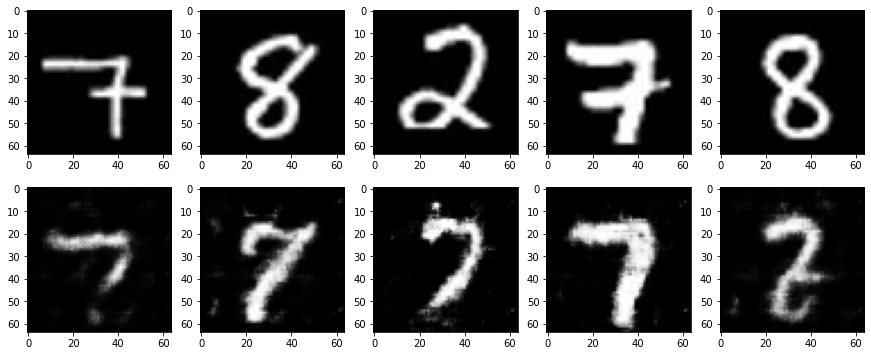

In [66]:
# 화상 생성
G_update.eval()
fake_img = G_update(z)

# 손실을 구한다
loss, loss_each, residual_loss_each = Anomaly_score(
    x, fake_img, D_update, Lambda=0.1)

# 손실 계산. 총 손실
loss_each = loss_each.cpu().detach().numpy()
print("total loss: ", np.round(loss_each, 0))

# 화상을 시각화
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 테스트 데이터를,
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터를 표시한다
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_img[i][0].cpu().detach().numpy(), 'gray')


## 6.3 Efficient GAN의 개요
* AnoGAN
    * 생성노이즈를 생성하기 위해 테스트 이미지와 생성 이미지의 오차를 역전파하여 z를 생신하고 학습함
* 이상 탐지에 많은 시간이 걸리는 문제를 해결하기 위해 Efficient GAN이 제안됨

## 6.4 Efficient GAN 구현 및 이상 탐지 실시
* 7, 8을 지도 데이터로 하여 이상 이미지 2를 검출

### 6.4.1 Generator 및 Discriminator 구현

In [74]:
class Generator(nn.Module):

    def __init__(self, z_dim=20):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(z_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.Linear(1024, 7*7*128),
            nn.BatchNorm1d(7*7*128),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=1,
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh())
        # 주의: 흑백 화상이므로 출력 채널은 하나 뿐임

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)

        # 전치 합성곱 층에 넣으므로 텐서 형태로 변형
        out = out.view(z.shape[0], 128, 7, 7)
        out = self.layer3(out)
        out = self.last(out)

        return out

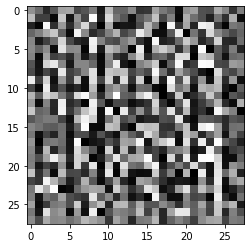

In [75]:
# 동작 확인
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20)
G.train()

# 입력 난수
# 배치 노멀라이제이션이 있으므로, 미니 배치 수는 2 이상
input_z = torch.randn(2, 20)

# 가짜 화상을 출력
fake_images = G(input_z)  # torch.Size([2, 1, 28, 28])
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

In [76]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20):
        super(Discriminator, self).__init__()

        # 화상 측 입력 처리
        self.x_layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 주의: 흑백 화상이므로 입력 채널은 하나 뿐임

        self.x_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        # 난수 측 입력 처리
        self.z_layer1 = nn.Linear(z_dim, 512)

        # 최후 판정
        self.last1 = nn.Sequential(
            nn.Linear(3648, 1024),
            nn.LeakyReLU(0.1, inplace=True))

        self.last2 = nn.Linear(1024, 1)

    def forward(self, x, z):

        # 화상 측 입력 처리
        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)

        # 난수 측 입력 처리
        z = z.view(z.shape[0], -1)
        z_out = self.z_layer1(z)

        # x_out과 z_out을 결합하여, 전결합층에서 판정
        x_out = x_out.view(-1, 64 * 7 * 7)
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)

        feature = out  # 최후에 채널을 하나로 집약
        feature = feature.view(feature.size()[0], -1)  # 2차원으로 변환

        out = self.last2(out)

        return out, feature


In [84]:
# 동작 확인
D = Discriminator(z_dim=20)

# 가짜 화상 생성
input_z = torch.randn(2, 20)
fake_images = G(input_z)

# 가짜 화상을 D에 입력
d_out, _ = D(fake_images, input_z)

# 출력 d_out에 Sigmoid를 곱해 0에서 1로 변환
print(nn.Sigmoid()(d_out))

tensor([[0.4601],
        [0.4730]], grad_fn=<SigmoidBackward>)


### 6.4.2 인코더 구현
* 합성곱 층과 LeakyReLU를 사용
* 출력: 입력 노이즈의 차원

In [79]:
class Encoder(nn.Module):

    def __init__(self, z_dim=20):
        super(Encoder, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3,
                      stride=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 주의: 흑백 화상이므로 입력 채널은 하나 뿐임

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True))

        # 여기까지 화상 크기는 7×7이 되어 있다
        self.last = nn.Linear(128 * 7 * 7, z_dim)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)

        # FC에 넣기 위해 텐서 형으로 변형
        out = out.view(-1, 128 * 7 * 7)
        out = self.last(out)

        return out


In [80]:
# 동작 확인
E = Encoder(z_dim=20)

# 입력할 화상 데이터
x = fake_images  # fake_images는 위에서 G로 작성한 것

# 화상에서 z를 Encode
z = E(x)

print(z.shape)
print(z)


torch.Size([2, 20])
tensor([[ 0.1559,  0.0648, -0.1778,  0.0104, -0.3606,  0.0299,  0.0760, -0.3411,
          0.1430, -0.0237,  0.3028,  0.0313,  0.0980,  0.0767,  0.2194,  0.2673,
          0.2319,  0.2672, -0.1894, -0.1642],
        [-0.4689,  0.1595,  0.0780, -0.1149, -0.1607, -0.0854,  0.1564,  0.0934,
          0.0963,  0.4912, -0.0880,  0.0442,  0.0884,  0.0839,  0.5274, -0.0193,
          0.1753, -0.0162,  0.1260, -0.4075]], grad_fn=<AddmmBackward>)


In [81]:
def make_datapath_list():
    """학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트를 작성한다. """

    train_img_list = list()  # 화상 파일 경로를 저장

    for img_idx in range(200):
        img_path = "./data/img_78_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list

In [88]:
class ImageTransform():
    """화상의 전처리 클래스"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)


In [89]:
class GAN_Img_Dataset(data.Dataset):
    """화상의 Dataset 클래스. PyTorch의 Dataset 클래스를 상속"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''화상 매수를 반환한다'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''전처리한 화상의 Tensor 형식 데이터 취득'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][폭]흑백

        # 화상 전처리
        img_transformed = self.transform(img)

        return img_transformed


In [90]:
# DataLoader 작성과 동작 확인

# 파일 리스트를 작성
train_img_list=make_datapath_list()

# Dataset 작성
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoader 작성
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 동작 확인
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 1, 28, 28])


In [91]:
# 모델을 학습시키는 함수를 작성
def train_model(G, D, E, dataloader, num_epochs):

    # GPU가 사용 가능한지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치: ", device)

    # 최적화 기법 설정
    lr_ge = 0.0001
    lr_d = 0.0001/4
    beta1, beta2 = 0.5, 0.999
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])

    # 오차함수 정의
    # BCEWithLogitsLoss는 입력에 시그모이드(logit)을 곱한 뒤에,
    # 이진 크로스 엔트로피를 계산
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # 파라미터를 하드코딩
    z_dim = 20
    mini_batch_size = 64

    # 네트워크를 GPU로
    G.to(device)
    E.to(device)
    D.to(device)

    G.train()  # 모델을 훈련 모드로
    E.train()  # 모델을 훈련 모드로
    D.train()  # 모델을 훈련 모드로

    # 네트워크가 어느 정도 고정되면, 고속화시킨다
    torch.backends.cudnn.benchmark = True

    # 화상의 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # 반복 카운터 설정
    iteration = 1
    logs = []

    # epoch 루프
    for epoch in range(num_epochs):

        # 개시 시간을 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epoch의 손실합
        epoch_e_loss = 0.0  # epoch의 손실합
        epoch_d_loss = 0.0  # epoch의 손실합

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('(train)')

        # 데이터 로더에서 minibatch씩 꺼내는 루프
        for imges in dataloader:

            # 미니 배치 크기가 1이면, 배치 노멀라이제이션에서 에러가 발생하므로 피한다
            if imges.size()[0] == 1:
                continue

            # 미니 배치 크기의 1 또는 0의 라벨 역할의 텐서를 작성
            # 정답 라벨과 가짜 라벨 작성
            # epoch의 마지막 반복은 미니 배치 수가 줄어든다
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # GPU가 사용 가능하면 GPU로 데이터를 보낸다
            imges = imges.to(device)

            # --------------------
            # 1. Discriminator 학습
            # --------------------
            # 진짜 화상을 판정　
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 오차를 계산
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # 역전파
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator 학습
            # --------------------
            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 오차를 계산
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # 역전파
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. Encoder 학습
            # --------------------
            # 진짜 화상 z를 추정
            z_out_real = E(imges)
            d_out_real, _ = D(imges, z_out_real)

            # 오차를 계산
            e_loss = criterion(d_out_real.view(-1), label_fake)

            # 역전파
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()

            # --------------------
            # 4. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1

        # epoch의 phase별 loss와 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f} ||Epoch_E_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size, epoch_e_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    print("총 반복 횟수: ", iteration)

    return G, D, E


In [92]:
# 네트워크 초기화
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # conv2d와 ConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        # 전결합층 Linear 초기화
        m.bias.data.fill_(0)


# 초기화 실시
G.apply(weights_init)
E.apply(weights_init)
D.apply(weights_init)

print("네트워크 초기화 완료")


네트워크 초기화 완료


In [93]:
# 학습 및 검증을 실행한다
# 15분 정도 걸립니다
num_epochs = 1500
G_update, D_update, E_update = train_model(
    G, D, E, dataloader=train_dataloader, num_epochs=num_epochs)


사용 장치:  cpu
-------------
Epoch 0/1500
-------------
(train)
-------------
epoch 0 || Epoch_D_Loss:0.1477 ||Epoch_G_Loss:0.0803 ||Epoch_E_Loss:0.0765
timer:  9.5374 sec.
-------------
Epoch 1/1500
-------------
(train)
-------------
epoch 1 || Epoch_D_Loss:0.1437 ||Epoch_G_Loss:0.0822 ||Epoch_E_Loss:0.0781
timer:  7.9600 sec.
-------------
Epoch 2/1500
-------------
(train)
-------------
epoch 2 || Epoch_D_Loss:0.1399 ||Epoch_G_Loss:0.0846 ||Epoch_E_Loss:0.0804
timer:  7.7738 sec.
-------------
Epoch 3/1500
-------------
(train)
-------------
epoch 3 || Epoch_D_Loss:0.1358 ||Epoch_G_Loss:0.0866 ||Epoch_E_Loss:0.0836
timer:  10.4958 sec.
-------------
Epoch 4/1500
-------------
(train)
-------------
epoch 4 || Epoch_D_Loss:0.1317 ||Epoch_G_Loss:0.0886 ||Epoch_E_Loss:0.0868
timer:  10.3388 sec.
-------------
Epoch 5/1500
-------------
(train)
-------------
epoch 5 || Epoch_D_Loss:0.1284 ||Epoch_G_Loss:0.0895 ||Epoch_E_Loss:0.0891
timer:  9.9363 sec.
-------------
Epoch 6/1500
-----------

-------------
epoch 51 || Epoch_D_Loss:0.0101 ||Epoch_G_Loss:0.3574 ||Epoch_E_Loss:0.3725
timer:  9.8235 sec.
-------------
Epoch 52/1500
-------------
(train)
-------------
epoch 52 || Epoch_D_Loss:0.0096 ||Epoch_G_Loss:0.3670 ||Epoch_E_Loss:0.3853
timer:  9.8075 sec.
-------------
Epoch 53/1500
-------------
(train)
-------------
epoch 53 || Epoch_D_Loss:0.0092 ||Epoch_G_Loss:0.3766 ||Epoch_E_Loss:0.3757
timer:  10.0908 sec.
-------------
Epoch 54/1500
-------------
(train)
-------------
epoch 54 || Epoch_D_Loss:0.0097 ||Epoch_G_Loss:0.3871 ||Epoch_E_Loss:0.3701
timer:  9.8271 sec.
-------------
Epoch 55/1500
-------------
(train)
-------------
epoch 55 || Epoch_D_Loss:0.0072 ||Epoch_G_Loss:0.4004 ||Epoch_E_Loss:0.4079
timer:  9.8327 sec.
-------------
Epoch 56/1500
-------------
(train)
-------------
epoch 56 || Epoch_D_Loss:0.0055 ||Epoch_G_Loss:0.4114 ||Epoch_E_Loss:0.4437
timer:  10.0627 sec.
-------------
Epoch 57/1500
-------------
(train)
-------------
epoch 57 || Epoch_D_Loss

-------------
epoch 102 || Epoch_D_Loss:0.0142 ||Epoch_G_Loss:0.3792 ||Epoch_E_Loss:0.4241
timer:  10.0756 sec.
-------------
Epoch 103/1500
-------------
(train)
-------------
epoch 103 || Epoch_D_Loss:0.0160 ||Epoch_G_Loss:0.4618 ||Epoch_E_Loss:0.4503
timer:  9.7987 sec.
-------------
Epoch 104/1500
-------------
(train)
-------------
epoch 104 || Epoch_D_Loss:0.0101 ||Epoch_G_Loss:0.3880 ||Epoch_E_Loss:0.4066
timer:  9.6786 sec.
-------------
Epoch 105/1500
-------------
(train)
-------------
epoch 105 || Epoch_D_Loss:0.0125 ||Epoch_G_Loss:0.3960 ||Epoch_E_Loss:0.3973
timer:  9.7653 sec.
-------------
Epoch 106/1500
-------------
(train)
-------------
epoch 106 || Epoch_D_Loss:0.0155 ||Epoch_G_Loss:0.3964 ||Epoch_E_Loss:0.4136
timer:  9.8972 sec.
-------------
Epoch 107/1500
-------------
(train)
-------------
epoch 107 || Epoch_D_Loss:0.0359 ||Epoch_G_Loss:0.3411 ||Epoch_E_Loss:0.3960
timer:  9.8124 sec.
-------------
Epoch 108/1500
-------------
(train)
-------------
epoch 108 || 

-------------
epoch 153 || Epoch_D_Loss:0.0708 ||Epoch_G_Loss:0.1974 ||Epoch_E_Loss:0.2251
timer:  9.6154 sec.
-------------
Epoch 154/1500
-------------
(train)
-------------
epoch 154 || Epoch_D_Loss:0.0759 ||Epoch_G_Loss:0.1892 ||Epoch_E_Loss:0.2123
timer:  9.5311 sec.
-------------
Epoch 155/1500
-------------
(train)
-------------
epoch 155 || Epoch_D_Loss:0.1038 ||Epoch_G_Loss:0.1684 ||Epoch_E_Loss:0.1970
timer:  9.6183 sec.
-------------
Epoch 156/1500
-------------
(train)
-------------
epoch 156 || Epoch_D_Loss:0.0950 ||Epoch_G_Loss:0.1897 ||Epoch_E_Loss:0.1974
timer:  9.5421 sec.
-------------
Epoch 157/1500
-------------
(train)
-------------
epoch 157 || Epoch_D_Loss:0.0867 ||Epoch_G_Loss:0.1673 ||Epoch_E_Loss:0.2130
timer:  9.5786 sec.
-------------
Epoch 158/1500
-------------
(train)
-------------
epoch 158 || Epoch_D_Loss:0.0858 ||Epoch_G_Loss:0.1934 ||Epoch_E_Loss:0.2076
timer:  9.9705 sec.
-------------
Epoch 159/1500
-------------
(train)
-------------
epoch 159 || E

-------------
epoch 204 || Epoch_D_Loss:0.0869 ||Epoch_G_Loss:0.1677 ||Epoch_E_Loss:0.1815
timer:  9.5493 sec.
-------------
Epoch 205/1500
-------------
(train)
-------------
epoch 205 || Epoch_D_Loss:0.0836 ||Epoch_G_Loss:0.1722 ||Epoch_E_Loss:0.1873
timer:  9.5681 sec.
-------------
Epoch 206/1500
-------------
(train)
-------------
epoch 206 || Epoch_D_Loss:0.1067 ||Epoch_G_Loss:0.1529 ||Epoch_E_Loss:0.1642
timer:  9.6263 sec.
-------------
Epoch 207/1500
-------------
(train)
-------------
epoch 207 || Epoch_D_Loss:0.1240 ||Epoch_G_Loss:0.1376 ||Epoch_E_Loss:0.1527
timer:  9.6301 sec.
-------------
Epoch 208/1500
-------------
(train)
-------------
epoch 208 || Epoch_D_Loss:0.1375 ||Epoch_G_Loss:0.1235 ||Epoch_E_Loss:0.1476
timer:  9.5345 sec.
-------------
Epoch 209/1500
-------------
(train)
-------------
epoch 209 || Epoch_D_Loss:0.1332 ||Epoch_G_Loss:0.1347 ||Epoch_E_Loss:0.1494
timer:  9.5715 sec.
-------------
Epoch 210/1500
-------------
(train)
-------------
epoch 210 || E

-------------
epoch 255 || Epoch_D_Loss:0.0964 ||Epoch_G_Loss:0.1517 ||Epoch_E_Loss:0.1500
timer:  11.4515 sec.
-------------
Epoch 256/1500
-------------
(train)
-------------
epoch 256 || Epoch_D_Loss:0.0973 ||Epoch_G_Loss:0.1416 ||Epoch_E_Loss:0.1554
timer:  10.8672 sec.
-------------
Epoch 257/1500
-------------
(train)
-------------
epoch 257 || Epoch_D_Loss:0.1111 ||Epoch_G_Loss:0.1400 ||Epoch_E_Loss:0.1374
timer:  9.8743 sec.
-------------
Epoch 258/1500
-------------
(train)
-------------
epoch 258 || Epoch_D_Loss:0.1228 ||Epoch_G_Loss:0.1215 ||Epoch_E_Loss:0.1314
timer:  10.6348 sec.
-------------
Epoch 259/1500
-------------
(train)
-------------
epoch 259 || Epoch_D_Loss:0.1222 ||Epoch_G_Loss:0.1189 ||Epoch_E_Loss:0.1274
timer:  12.5135 sec.
-------------
Epoch 260/1500
-------------
(train)
-------------
epoch 260 || Epoch_D_Loss:0.1328 ||Epoch_G_Loss:0.1094 ||Epoch_E_Loss:0.1210
timer:  10.0300 sec.
-------------
Epoch 261/1500
-------------
(train)
-------------
epoch 261

-------------
epoch 306 || Epoch_D_Loss:0.1068 ||Epoch_G_Loss:0.1301 ||Epoch_E_Loss:0.1563
timer:  9.6888 sec.
-------------
Epoch 307/1500
-------------
(train)
-------------
epoch 307 || Epoch_D_Loss:0.1009 ||Epoch_G_Loss:0.1486 ||Epoch_E_Loss:0.1580
timer:  10.8318 sec.
-------------
Epoch 308/1500
-------------
(train)
-------------
epoch 308 || Epoch_D_Loss:0.1224 ||Epoch_G_Loss:0.1333 ||Epoch_E_Loss:0.1382
timer:  10.1761 sec.
-------------
Epoch 309/1500
-------------
(train)
-------------
epoch 309 || Epoch_D_Loss:0.1524 ||Epoch_G_Loss:0.1027 ||Epoch_E_Loss:0.1208
timer:  10.9806 sec.
-------------
Epoch 310/1500
-------------
(train)
-------------
epoch 310 || Epoch_D_Loss:0.1504 ||Epoch_G_Loss:0.1026 ||Epoch_E_Loss:0.1240
timer:  10.4858 sec.
-------------
Epoch 311/1500
-------------
(train)
-------------
epoch 311 || Epoch_D_Loss:0.1382 ||Epoch_G_Loss:0.1204 ||Epoch_E_Loss:0.1306
timer:  10.3345 sec.
-------------
Epoch 312/1500
-------------
(train)
-------------
epoch 312

-------------
epoch 357 || Epoch_D_Loss:0.1465 ||Epoch_G_Loss:0.1027 ||Epoch_E_Loss:0.1168
timer:  10.3481 sec.
-------------
Epoch 358/1500
-------------
(train)
-------------
epoch 358 || Epoch_D_Loss:0.1278 ||Epoch_G_Loss:0.1153 ||Epoch_E_Loss:0.1245
timer:  10.0107 sec.
-------------
Epoch 359/1500
-------------
(train)
-------------
epoch 359 || Epoch_D_Loss:0.1390 ||Epoch_G_Loss:0.1113 ||Epoch_E_Loss:0.1228
timer:  10.2285 sec.
-------------
Epoch 360/1500
-------------
(train)
-------------
epoch 360 || Epoch_D_Loss:0.1434 ||Epoch_G_Loss:0.0974 ||Epoch_E_Loss:0.1165
timer:  10.2393 sec.
-------------
Epoch 361/1500
-------------
(train)
-------------
epoch 361 || Epoch_D_Loss:0.1535 ||Epoch_G_Loss:0.0908 ||Epoch_E_Loss:0.1066
timer:  10.0017 sec.
-------------
Epoch 362/1500
-------------
(train)
-------------
epoch 362 || Epoch_D_Loss:0.1596 ||Epoch_G_Loss:0.1028 ||Epoch_E_Loss:0.1019
timer:  10.2099 sec.
-------------
Epoch 363/1500
-------------
(train)
-------------
epoch 36

-------------
epoch 408 || Epoch_D_Loss:0.1512 ||Epoch_G_Loss:0.1004 ||Epoch_E_Loss:0.1073
timer:  9.7526 sec.
-------------
Epoch 409/1500
-------------
(train)
-------------
epoch 409 || Epoch_D_Loss:0.1446 ||Epoch_G_Loss:0.1012 ||Epoch_E_Loss:0.1098
timer:  9.9045 sec.
-------------
Epoch 410/1500
-------------
(train)
-------------
epoch 410 || Epoch_D_Loss:0.1410 ||Epoch_G_Loss:0.1125 ||Epoch_E_Loss:0.1097
timer:  10.7775 sec.
-------------
Epoch 411/1500
-------------
(train)
-------------
epoch 411 || Epoch_D_Loss:0.1265 ||Epoch_G_Loss:0.1119 ||Epoch_E_Loss:0.1186
timer:  9.8064 sec.
-------------
Epoch 412/1500
-------------
(train)
-------------
epoch 412 || Epoch_D_Loss:0.1238 ||Epoch_G_Loss:0.1260 ||Epoch_E_Loss:0.1168
timer:  9.5307 sec.
-------------
Epoch 413/1500
-------------
(train)
-------------
epoch 413 || Epoch_D_Loss:0.1067 ||Epoch_G_Loss:0.1205 ||Epoch_E_Loss:0.1320
timer:  10.0235 sec.
-------------
Epoch 414/1500
-------------
(train)
-------------
epoch 414 ||

-------------
epoch 459 || Epoch_D_Loss:0.1369 ||Epoch_G_Loss:0.0977 ||Epoch_E_Loss:0.1214
timer:  11.3829 sec.
-------------
Epoch 460/1500
-------------
(train)
-------------
epoch 460 || Epoch_D_Loss:0.1444 ||Epoch_G_Loss:0.1015 ||Epoch_E_Loss:0.1119
timer:  10.9289 sec.
-------------
Epoch 461/1500
-------------
(train)
-------------
epoch 461 || Epoch_D_Loss:0.1292 ||Epoch_G_Loss:0.1155 ||Epoch_E_Loss:0.1203
timer:  10.5839 sec.
-------------
Epoch 462/1500
-------------
(train)
-------------
epoch 462 || Epoch_D_Loss:0.1258 ||Epoch_G_Loss:0.1104 ||Epoch_E_Loss:0.1321
timer:  11.5487 sec.
-------------
Epoch 463/1500
-------------
(train)
-------------
epoch 463 || Epoch_D_Loss:0.1519 ||Epoch_G_Loss:0.0995 ||Epoch_E_Loss:0.1080
timer:  11.1412 sec.
-------------
Epoch 464/1500
-------------
(train)
-------------
epoch 464 || Epoch_D_Loss:0.1630 ||Epoch_G_Loss:0.0825 ||Epoch_E_Loss:0.1018
timer:  10.4673 sec.
-------------
Epoch 465/1500
-------------
(train)
-------------
epoch 46

-------------
epoch 510 || Epoch_D_Loss:0.1337 ||Epoch_G_Loss:0.1088 ||Epoch_E_Loss:0.1169
timer:  9.3206 sec.
-------------
Epoch 511/1500
-------------
(train)
-------------
epoch 511 || Epoch_D_Loss:0.1343 ||Epoch_G_Loss:0.0982 ||Epoch_E_Loss:0.1194
timer:  9.9519 sec.
-------------
Epoch 512/1500
-------------
(train)
-------------
epoch 512 || Epoch_D_Loss:0.1503 ||Epoch_G_Loss:0.0948 ||Epoch_E_Loss:0.1085
timer:  9.3483 sec.
-------------
Epoch 513/1500
-------------
(train)
-------------
epoch 513 || Epoch_D_Loss:0.1554 ||Epoch_G_Loss:0.0816 ||Epoch_E_Loss:0.1060
timer:  9.3146 sec.
-------------
Epoch 514/1500
-------------
(train)
-------------
epoch 514 || Epoch_D_Loss:0.1631 ||Epoch_G_Loss:0.0824 ||Epoch_E_Loss:0.1059
timer:  9.3428 sec.
-------------
Epoch 515/1500
-------------
(train)
-------------
epoch 515 || Epoch_D_Loss:0.1537 ||Epoch_G_Loss:0.0928 ||Epoch_E_Loss:0.1073
timer:  9.4030 sec.
-------------
Epoch 516/1500
-------------
(train)
-------------
epoch 516 || E

-------------
epoch 561 || Epoch_D_Loss:0.1485 ||Epoch_G_Loss:0.0926 ||Epoch_E_Loss:0.1011
timer:  9.2691 sec.
-------------
Epoch 562/1500
-------------
(train)
-------------
epoch 562 || Epoch_D_Loss:0.1444 ||Epoch_G_Loss:0.0915 ||Epoch_E_Loss:0.1063
timer:  9.3373 sec.
-------------
Epoch 563/1500
-------------
(train)
-------------
epoch 563 || Epoch_D_Loss:0.1420 ||Epoch_G_Loss:0.1015 ||Epoch_E_Loss:0.1044
timer:  9.2927 sec.
-------------
Epoch 564/1500
-------------
(train)
-------------
epoch 564 || Epoch_D_Loss:0.1384 ||Epoch_G_Loss:0.1060 ||Epoch_E_Loss:0.1050
timer:  9.6626 sec.
-------------
Epoch 565/1500
-------------
(train)
-------------
epoch 565 || Epoch_D_Loss:0.1445 ||Epoch_G_Loss:0.0988 ||Epoch_E_Loss:0.0990
timer:  9.2656 sec.
-------------
Epoch 566/1500
-------------
(train)
-------------
epoch 566 || Epoch_D_Loss:0.1476 ||Epoch_G_Loss:0.0854 ||Epoch_E_Loss:0.1019
timer:  9.3499 sec.
-------------
Epoch 567/1500
-------------
(train)
-------------
epoch 567 || E

-------------
epoch 612 || Epoch_D_Loss:0.1351 ||Epoch_G_Loss:0.0949 ||Epoch_E_Loss:0.1038
timer:  4.1969 sec.
-------------
Epoch 613/1500
-------------
(train)
-------------
epoch 613 || Epoch_D_Loss:0.1326 ||Epoch_G_Loss:0.1042 ||Epoch_E_Loss:0.1025
timer:  4.1119 sec.
-------------
Epoch 614/1500
-------------
(train)
-------------
epoch 614 || Epoch_D_Loss:0.1260 ||Epoch_G_Loss:0.1046 ||Epoch_E_Loss:0.1107
timer:  4.0842 sec.
-------------
Epoch 615/1500
-------------
(train)
-------------
epoch 615 || Epoch_D_Loss:0.1399 ||Epoch_G_Loss:0.1074 ||Epoch_E_Loss:0.1014
timer:  4.1643 sec.
-------------
Epoch 616/1500
-------------
(train)
-------------
epoch 616 || Epoch_D_Loss:0.1529 ||Epoch_G_Loss:0.0854 ||Epoch_E_Loss:0.0942
timer:  4.1825 sec.
-------------
Epoch 617/1500
-------------
(train)
-------------
epoch 617 || Epoch_D_Loss:0.1606 ||Epoch_G_Loss:0.0711 ||Epoch_E_Loss:0.0880
timer:  4.0953 sec.
-------------
Epoch 618/1500
-------------
(train)
-------------
epoch 618 || E

-------------
epoch 663 || Epoch_D_Loss:0.1189 ||Epoch_G_Loss:0.1140 ||Epoch_E_Loss:0.1220
timer:  4.0990 sec.
-------------
Epoch 664/1500
-------------
(train)
-------------
epoch 664 || Epoch_D_Loss:0.1239 ||Epoch_G_Loss:0.1040 ||Epoch_E_Loss:0.1151
timer:  4.0442 sec.
-------------
Epoch 665/1500
-------------
(train)
-------------
epoch 665 || Epoch_D_Loss:0.1371 ||Epoch_G_Loss:0.1045 ||Epoch_E_Loss:0.1067
timer:  4.1045 sec.
-------------
Epoch 666/1500
-------------
(train)
-------------
epoch 666 || Epoch_D_Loss:0.1254 ||Epoch_G_Loss:0.1116 ||Epoch_E_Loss:0.1115
timer:  4.2333 sec.
-------------
Epoch 667/1500
-------------
(train)
-------------
epoch 667 || Epoch_D_Loss:0.1140 ||Epoch_G_Loss:0.1093 ||Epoch_E_Loss:0.1254
timer:  4.1553 sec.
-------------
Epoch 668/1500
-------------
(train)
-------------
epoch 668 || Epoch_D_Loss:0.1129 ||Epoch_G_Loss:0.1193 ||Epoch_E_Loss:0.1242
timer:  4.2730 sec.
-------------
Epoch 669/1500
-------------
(train)
-------------
epoch 669 || E

-------------
epoch 714 || Epoch_D_Loss:0.1304 ||Epoch_G_Loss:0.0975 ||Epoch_E_Loss:0.1121
timer:  4.2232 sec.
-------------
Epoch 715/1500
-------------
(train)
-------------
epoch 715 || Epoch_D_Loss:0.1267 ||Epoch_G_Loss:0.1063 ||Epoch_E_Loss:0.1109
timer:  4.1304 sec.
-------------
Epoch 716/1500
-------------
(train)
-------------
epoch 716 || Epoch_D_Loss:0.1209 ||Epoch_G_Loss:0.1037 ||Epoch_E_Loss:0.1191
timer:  4.1437 sec.
-------------
Epoch 717/1500
-------------
(train)
-------------
epoch 717 || Epoch_D_Loss:0.1187 ||Epoch_G_Loss:0.1127 ||Epoch_E_Loss:0.1131
timer:  4.1069 sec.
-------------
Epoch 718/1500
-------------
(train)
-------------
epoch 718 || Epoch_D_Loss:0.1204 ||Epoch_G_Loss:0.1040 ||Epoch_E_Loss:0.1190
timer:  4.1475 sec.
-------------
Epoch 719/1500
-------------
(train)
-------------
epoch 719 || Epoch_D_Loss:0.1317 ||Epoch_G_Loss:0.1115 ||Epoch_E_Loss:0.1056
timer:  4.1619 sec.
-------------
Epoch 720/1500
-------------
(train)
-------------
epoch 720 || E

-------------
epoch 765 || Epoch_D_Loss:0.1205 ||Epoch_G_Loss:0.1082 ||Epoch_E_Loss:0.1154
timer:  4.0630 sec.
-------------
Epoch 766/1500
-------------
(train)
-------------
epoch 766 || Epoch_D_Loss:0.1336 ||Epoch_G_Loss:0.0978 ||Epoch_E_Loss:0.1113
timer:  4.1182 sec.
-------------
Epoch 767/1500
-------------
(train)
-------------
epoch 767 || Epoch_D_Loss:0.1499 ||Epoch_G_Loss:0.0862 ||Epoch_E_Loss:0.0924
timer:  4.1844 sec.
-------------
Epoch 768/1500
-------------
(train)
-------------
epoch 768 || Epoch_D_Loss:0.1493 ||Epoch_G_Loss:0.0815 ||Epoch_E_Loss:0.1034
timer:  4.0659 sec.
-------------
Epoch 769/1500
-------------
(train)
-------------
epoch 769 || Epoch_D_Loss:0.1309 ||Epoch_G_Loss:0.1055 ||Epoch_E_Loss:0.1035
timer:  4.0238 sec.
-------------
Epoch 770/1500
-------------
(train)
-------------
epoch 770 || Epoch_D_Loss:0.1332 ||Epoch_G_Loss:0.0987 ||Epoch_E_Loss:0.1051
timer:  4.0979 sec.
-------------
Epoch 771/1500
-------------
(train)
-------------
epoch 771 || E

-------------
epoch 816 || Epoch_D_Loss:0.1051 ||Epoch_G_Loss:0.1302 ||Epoch_E_Loss:0.1279
timer:  4.2015 sec.
-------------
Epoch 817/1500
-------------
(train)
-------------
epoch 817 || Epoch_D_Loss:0.1209 ||Epoch_G_Loss:0.1105 ||Epoch_E_Loss:0.1311
timer:  4.1513 sec.
-------------
Epoch 818/1500
-------------
(train)
-------------
epoch 818 || Epoch_D_Loss:0.1485 ||Epoch_G_Loss:0.1003 ||Epoch_E_Loss:0.1009
timer:  4.1975 sec.
-------------
Epoch 819/1500
-------------
(train)
-------------
epoch 819 || Epoch_D_Loss:0.1473 ||Epoch_G_Loss:0.0945 ||Epoch_E_Loss:0.0997
timer:  4.2293 sec.
-------------
Epoch 820/1500
-------------
(train)
-------------
epoch 820 || Epoch_D_Loss:0.1423 ||Epoch_G_Loss:0.0927 ||Epoch_E_Loss:0.1077
timer:  4.1398 sec.
-------------
Epoch 821/1500
-------------
(train)
-------------
epoch 821 || Epoch_D_Loss:0.1213 ||Epoch_G_Loss:0.1172 ||Epoch_E_Loss:0.1203
timer:  4.1892 sec.
-------------
Epoch 822/1500
-------------
(train)
-------------
epoch 822 || E

-------------
epoch 867 || Epoch_D_Loss:0.1468 ||Epoch_G_Loss:0.0895 ||Epoch_E_Loss:0.1029
timer:  4.1805 sec.
-------------
Epoch 868/1500
-------------
(train)
-------------
epoch 868 || Epoch_D_Loss:0.1409 ||Epoch_G_Loss:0.0942 ||Epoch_E_Loss:0.1003
timer:  4.1655 sec.
-------------
Epoch 869/1500
-------------
(train)
-------------
epoch 869 || Epoch_D_Loss:0.1355 ||Epoch_G_Loss:0.0961 ||Epoch_E_Loss:0.1118
timer:  4.1420 sec.
-------------
Epoch 870/1500
-------------
(train)
-------------
epoch 870 || Epoch_D_Loss:0.1267 ||Epoch_G_Loss:0.1079 ||Epoch_E_Loss:0.1107
timer:  4.2124 sec.
-------------
Epoch 871/1500
-------------
(train)
-------------
epoch 871 || Epoch_D_Loss:0.1179 ||Epoch_G_Loss:0.1066 ||Epoch_E_Loss:0.1215
timer:  4.1739 sec.
-------------
Epoch 872/1500
-------------
(train)
-------------
epoch 872 || Epoch_D_Loss:0.1225 ||Epoch_G_Loss:0.1070 ||Epoch_E_Loss:0.1119
timer:  4.1979 sec.
-------------
Epoch 873/1500
-------------
(train)
-------------
epoch 873 || E

-------------
epoch 918 || Epoch_D_Loss:0.1506 ||Epoch_G_Loss:0.1005 ||Epoch_E_Loss:0.1000
timer:  4.1173 sec.
-------------
Epoch 919/1500
-------------
(train)
-------------
epoch 919 || Epoch_D_Loss:0.1253 ||Epoch_G_Loss:0.1141 ||Epoch_E_Loss:0.1183
timer:  4.2306 sec.
-------------
Epoch 920/1500
-------------
(train)
-------------
epoch 920 || Epoch_D_Loss:0.1013 ||Epoch_G_Loss:0.1270 ||Epoch_E_Loss:0.1401
timer:  4.1551 sec.
-------------
Epoch 921/1500
-------------
(train)
-------------
epoch 921 || Epoch_D_Loss:0.0937 ||Epoch_G_Loss:0.1288 ||Epoch_E_Loss:0.1425
timer:  4.1777 sec.
-------------
Epoch 922/1500
-------------
(train)
-------------
epoch 922 || Epoch_D_Loss:0.0993 ||Epoch_G_Loss:0.1258 ||Epoch_E_Loss:0.1382
timer:  4.1473 sec.
-------------
Epoch 923/1500
-------------
(train)
-------------
epoch 923 || Epoch_D_Loss:0.1009 ||Epoch_G_Loss:0.1282 ||Epoch_E_Loss:0.1334
timer:  4.1567 sec.
-------------
Epoch 924/1500
-------------
(train)
-------------
epoch 924 || E

-------------
epoch 969 || Epoch_D_Loss:0.1159 ||Epoch_G_Loss:0.1292 ||Epoch_E_Loss:0.1199
timer:  4.1703 sec.
-------------
Epoch 970/1500
-------------
(train)
-------------
epoch 970 || Epoch_D_Loss:0.1247 ||Epoch_G_Loss:0.1055 ||Epoch_E_Loss:0.1295
timer:  4.1389 sec.
-------------
Epoch 971/1500
-------------
(train)
-------------
epoch 971 || Epoch_D_Loss:0.1429 ||Epoch_G_Loss:0.0977 ||Epoch_E_Loss:0.1046
timer:  4.1926 sec.
-------------
Epoch 972/1500
-------------
(train)
-------------
epoch 972 || Epoch_D_Loss:0.1435 ||Epoch_G_Loss:0.0967 ||Epoch_E_Loss:0.1093
timer:  4.0662 sec.
-------------
Epoch 973/1500
-------------
(train)
-------------
epoch 973 || Epoch_D_Loss:0.1218 ||Epoch_G_Loss:0.1169 ||Epoch_E_Loss:0.1153
timer:  4.1529 sec.
-------------
Epoch 974/1500
-------------
(train)
-------------
epoch 974 || Epoch_D_Loss:0.1063 ||Epoch_G_Loss:0.1363 ||Epoch_E_Loss:0.1332
timer:  4.1214 sec.
-------------
Epoch 975/1500
-------------
(train)
-------------
epoch 975 || E

-------------
epoch 1020 || Epoch_D_Loss:0.1124 ||Epoch_G_Loss:0.1184 ||Epoch_E_Loss:0.1283
timer:  4.1565 sec.
-------------
Epoch 1021/1500
-------------
(train)
-------------
epoch 1021 || Epoch_D_Loss:0.1236 ||Epoch_G_Loss:0.1238 ||Epoch_E_Loss:0.1176
timer:  4.0903 sec.
-------------
Epoch 1022/1500
-------------
(train)
-------------
epoch 1022 || Epoch_D_Loss:0.1301 ||Epoch_G_Loss:0.1050 ||Epoch_E_Loss:0.1272
timer:  4.1236 sec.
-------------
Epoch 1023/1500
-------------
(train)
-------------
epoch 1023 || Epoch_D_Loss:0.1239 ||Epoch_G_Loss:0.1096 ||Epoch_E_Loss:0.1197
timer:  4.0843 sec.
-------------
Epoch 1024/1500
-------------
(train)
-------------
epoch 1024 || Epoch_D_Loss:0.1140 ||Epoch_G_Loss:0.1112 ||Epoch_E_Loss:0.1334
timer:  4.0925 sec.
-------------
Epoch 1025/1500
-------------
(train)
-------------
epoch 1025 || Epoch_D_Loss:0.1189 ||Epoch_G_Loss:0.1294 ||Epoch_E_Loss:0.1260
timer:  4.1570 sec.
-------------
Epoch 1026/1500
-------------
(train)
-------------
ep

-------------
epoch 1070 || Epoch_D_Loss:0.1196 ||Epoch_G_Loss:0.1184 ||Epoch_E_Loss:0.1226
timer:  4.1454 sec.
-------------
Epoch 1071/1500
-------------
(train)
-------------
epoch 1071 || Epoch_D_Loss:0.1224 ||Epoch_G_Loss:0.1212 ||Epoch_E_Loss:0.1238
timer:  4.2191 sec.
-------------
Epoch 1072/1500
-------------
(train)
-------------
epoch 1072 || Epoch_D_Loss:0.1134 ||Epoch_G_Loss:0.1176 ||Epoch_E_Loss:0.1244
timer:  4.1600 sec.
-------------
Epoch 1073/1500
-------------
(train)
-------------
epoch 1073 || Epoch_D_Loss:0.1191 ||Epoch_G_Loss:0.1135 ||Epoch_E_Loss:0.1255
timer:  4.1280 sec.
-------------
Epoch 1074/1500
-------------
(train)
-------------
epoch 1074 || Epoch_D_Loss:0.1104 ||Epoch_G_Loss:0.1243 ||Epoch_E_Loss:0.1275
timer:  4.1214 sec.
-------------
Epoch 1075/1500
-------------
(train)
-------------
epoch 1075 || Epoch_D_Loss:0.1011 ||Epoch_G_Loss:0.1394 ||Epoch_E_Loss:0.1449
timer:  4.1682 sec.
-------------
Epoch 1076/1500
-------------
(train)
-------------
ep

-------------
epoch 1120 || Epoch_D_Loss:0.1009 ||Epoch_G_Loss:0.1233 ||Epoch_E_Loss:0.1462
timer:  4.0830 sec.
-------------
Epoch 1121/1500
-------------
(train)
-------------
epoch 1121 || Epoch_D_Loss:0.1202 ||Epoch_G_Loss:0.1248 ||Epoch_E_Loss:0.1249
timer:  4.1034 sec.
-------------
Epoch 1122/1500
-------------
(train)
-------------
epoch 1122 || Epoch_D_Loss:0.1207 ||Epoch_G_Loss:0.1117 ||Epoch_E_Loss:0.1235
timer:  4.1318 sec.
-------------
Epoch 1123/1500
-------------
(train)
-------------
epoch 1123 || Epoch_D_Loss:0.1295 ||Epoch_G_Loss:0.1053 ||Epoch_E_Loss:0.1240
timer:  4.1673 sec.
-------------
Epoch 1124/1500
-------------
(train)
-------------
epoch 1124 || Epoch_D_Loss:0.1125 ||Epoch_G_Loss:0.1215 ||Epoch_E_Loss:0.1297
timer:  4.1829 sec.
-------------
Epoch 1125/1500
-------------
(train)
-------------
epoch 1125 || Epoch_D_Loss:0.0943 ||Epoch_G_Loss:0.1326 ||Epoch_E_Loss:0.1469
timer:  4.1770 sec.
-------------
Epoch 1126/1500
-------------
(train)
-------------
ep

-------------
epoch 1170 || Epoch_D_Loss:0.0924 ||Epoch_G_Loss:0.1338 ||Epoch_E_Loss:0.1494
timer:  4.1137 sec.
-------------
Epoch 1171/1500
-------------
(train)
-------------
epoch 1171 || Epoch_D_Loss:0.0948 ||Epoch_G_Loss:0.1459 ||Epoch_E_Loss:0.1477
timer:  4.1497 sec.
-------------
Epoch 1172/1500
-------------
(train)
-------------
epoch 1172 || Epoch_D_Loss:0.1145 ||Epoch_G_Loss:0.1188 ||Epoch_E_Loss:0.1255
timer:  4.1526 sec.
-------------
Epoch 1173/1500
-------------
(train)
-------------
epoch 1173 || Epoch_D_Loss:0.1387 ||Epoch_G_Loss:0.1055 ||Epoch_E_Loss:0.1128
timer:  4.1518 sec.
-------------
Epoch 1174/1500
-------------
(train)
-------------
epoch 1174 || Epoch_D_Loss:0.1250 ||Epoch_G_Loss:0.1066 ||Epoch_E_Loss:0.1177
timer:  4.1613 sec.
-------------
Epoch 1175/1500
-------------
(train)
-------------
epoch 1175 || Epoch_D_Loss:0.1023 ||Epoch_G_Loss:0.1207 ||Epoch_E_Loss:0.1354
timer:  4.1710 sec.
-------------
Epoch 1176/1500
-------------
(train)
-------------
ep

-------------
epoch 1220 || Epoch_D_Loss:0.1046 ||Epoch_G_Loss:0.1377 ||Epoch_E_Loss:0.1328
timer:  4.0991 sec.
-------------
Epoch 1221/1500
-------------
(train)
-------------
epoch 1221 || Epoch_D_Loss:0.0950 ||Epoch_G_Loss:0.1358 ||Epoch_E_Loss:0.1444
timer:  4.0727 sec.
-------------
Epoch 1222/1500
-------------
(train)
-------------
epoch 1222 || Epoch_D_Loss:0.0957 ||Epoch_G_Loss:0.1260 ||Epoch_E_Loss:0.1449
timer:  4.0497 sec.
-------------
Epoch 1223/1500
-------------
(train)
-------------
epoch 1223 || Epoch_D_Loss:0.1021 ||Epoch_G_Loss:0.1352 ||Epoch_E_Loss:0.1396
timer:  4.0490 sec.
-------------
Epoch 1224/1500
-------------
(train)
-------------
epoch 1224 || Epoch_D_Loss:0.0996 ||Epoch_G_Loss:0.1345 ||Epoch_E_Loss:0.1456
timer:  4.0454 sec.
-------------
Epoch 1225/1500
-------------
(train)
-------------
epoch 1225 || Epoch_D_Loss:0.1100 ||Epoch_G_Loss:0.1325 ||Epoch_E_Loss:0.1367
timer:  4.0715 sec.
-------------
Epoch 1226/1500
-------------
(train)
-------------
ep

-------------
epoch 1270 || Epoch_D_Loss:0.0950 ||Epoch_G_Loss:0.1397 ||Epoch_E_Loss:0.1566
timer:  4.1143 sec.
-------------
Epoch 1271/1500
-------------
(train)
-------------
epoch 1271 || Epoch_D_Loss:0.1088 ||Epoch_G_Loss:0.1471 ||Epoch_E_Loss:0.1383
timer:  4.1650 sec.
-------------
Epoch 1272/1500
-------------
(train)
-------------
epoch 1272 || Epoch_D_Loss:0.1215 ||Epoch_G_Loss:0.1173 ||Epoch_E_Loss:0.1380
timer:  4.1231 sec.
-------------
Epoch 1273/1500
-------------
(train)
-------------
epoch 1273 || Epoch_D_Loss:0.1351 ||Epoch_G_Loss:0.1133 ||Epoch_E_Loss:0.1212
timer:  4.0851 sec.
-------------
Epoch 1274/1500
-------------
(train)
-------------
epoch 1274 || Epoch_D_Loss:0.1130 ||Epoch_G_Loss:0.1347 ||Epoch_E_Loss:0.1345
timer:  4.1052 sec.
-------------
Epoch 1275/1500
-------------
(train)
-------------
epoch 1275 || Epoch_D_Loss:0.1014 ||Epoch_G_Loss:0.1430 ||Epoch_E_Loss:0.1533
timer:  4.1006 sec.
-------------
Epoch 1276/1500
-------------
(train)
-------------
ep

-------------
epoch 1320 || Epoch_D_Loss:0.1236 ||Epoch_G_Loss:0.1189 ||Epoch_E_Loss:0.1212
timer:  4.1821 sec.
-------------
Epoch 1321/1500
-------------
(train)
-------------
epoch 1321 || Epoch_D_Loss:0.1256 ||Epoch_G_Loss:0.1065 ||Epoch_E_Loss:0.1294
timer:  4.1388 sec.
-------------
Epoch 1322/1500
-------------
(train)
-------------
epoch 1322 || Epoch_D_Loss:0.1181 ||Epoch_G_Loss:0.1401 ||Epoch_E_Loss:0.1397
timer:  4.1889 sec.
-------------
Epoch 1323/1500
-------------
(train)
-------------
epoch 1323 || Epoch_D_Loss:0.0969 ||Epoch_G_Loss:0.1364 ||Epoch_E_Loss:0.1477
timer:  4.0980 sec.
-------------
Epoch 1324/1500
-------------
(train)
-------------
epoch 1324 || Epoch_D_Loss:0.1089 ||Epoch_G_Loss:0.1223 ||Epoch_E_Loss:0.1361
timer:  4.1378 sec.
-------------
Epoch 1325/1500
-------------
(train)
-------------
epoch 1325 || Epoch_D_Loss:0.1187 ||Epoch_G_Loss:0.1237 ||Epoch_E_Loss:0.1278
timer:  4.0666 sec.
-------------
Epoch 1326/1500
-------------
(train)
-------------
ep

-------------
epoch 1370 || Epoch_D_Loss:0.1001 ||Epoch_G_Loss:0.1427 ||Epoch_E_Loss:0.1440
timer:  4.1829 sec.
-------------
Epoch 1371/1500
-------------
(train)
-------------
epoch 1371 || Epoch_D_Loss:0.0911 ||Epoch_G_Loss:0.1474 ||Epoch_E_Loss:0.1545
timer:  4.1543 sec.
-------------
Epoch 1372/1500
-------------
(train)
-------------
epoch 1372 || Epoch_D_Loss:0.0889 ||Epoch_G_Loss:0.1329 ||Epoch_E_Loss:0.1636
timer:  4.1867 sec.
-------------
Epoch 1373/1500
-------------
(train)
-------------
epoch 1373 || Epoch_D_Loss:0.1055 ||Epoch_G_Loss:0.1362 ||Epoch_E_Loss:0.1479
timer:  4.1997 sec.
-------------
Epoch 1374/1500
-------------
(train)
-------------
epoch 1374 || Epoch_D_Loss:0.1065 ||Epoch_G_Loss:0.1430 ||Epoch_E_Loss:0.1434
timer:  4.1525 sec.
-------------
Epoch 1375/1500
-------------
(train)
-------------
epoch 1375 || Epoch_D_Loss:0.1024 ||Epoch_G_Loss:0.1246 ||Epoch_E_Loss:0.1538
timer:  4.1157 sec.
-------------
Epoch 1376/1500
-------------
(train)
-------------
ep

-------------
epoch 1420 || Epoch_D_Loss:0.1148 ||Epoch_G_Loss:0.1276 ||Epoch_E_Loss:0.1437
timer:  4.1636 sec.
-------------
Epoch 1421/1500
-------------
(train)
-------------
epoch 1421 || Epoch_D_Loss:0.0958 ||Epoch_G_Loss:0.1439 ||Epoch_E_Loss:0.1649
timer:  4.1600 sec.
-------------
Epoch 1422/1500
-------------
(train)
-------------
epoch 1422 || Epoch_D_Loss:0.0859 ||Epoch_G_Loss:0.1564 ||Epoch_E_Loss:0.1667
timer:  4.1481 sec.
-------------
Epoch 1423/1500
-------------
(train)
-------------
epoch 1423 || Epoch_D_Loss:0.0769 ||Epoch_G_Loss:0.1703 ||Epoch_E_Loss:0.1710
timer:  4.1350 sec.
-------------
Epoch 1424/1500
-------------
(train)
-------------
epoch 1424 || Epoch_D_Loss:0.0896 ||Epoch_G_Loss:0.1551 ||Epoch_E_Loss:0.1573
timer:  4.1880 sec.
-------------
Epoch 1425/1500
-------------
(train)
-------------
epoch 1425 || Epoch_D_Loss:0.1005 ||Epoch_G_Loss:0.1397 ||Epoch_E_Loss:0.1583
timer:  4.1971 sec.
-------------
Epoch 1426/1500
-------------
(train)
-------------
ep

-------------
epoch 1470 || Epoch_D_Loss:0.0990 ||Epoch_G_Loss:0.1347 ||Epoch_E_Loss:0.1552
timer:  4.1870 sec.
-------------
Epoch 1471/1500
-------------
(train)
-------------
epoch 1471 || Epoch_D_Loss:0.1456 ||Epoch_G_Loss:0.1202 ||Epoch_E_Loss:0.1238
timer:  4.2338 sec.
-------------
Epoch 1472/1500
-------------
(train)
-------------
epoch 1472 || Epoch_D_Loss:0.1271 ||Epoch_G_Loss:0.1232 ||Epoch_E_Loss:0.1227
timer:  4.2985 sec.
-------------
Epoch 1473/1500
-------------
(train)
-------------
epoch 1473 || Epoch_D_Loss:0.1010 ||Epoch_G_Loss:0.1411 ||Epoch_E_Loss:0.1598
timer:  4.2615 sec.
-------------
Epoch 1474/1500
-------------
(train)
-------------
epoch 1474 || Epoch_D_Loss:0.0837 ||Epoch_G_Loss:0.1582 ||Epoch_E_Loss:0.1757
timer:  4.2349 sec.
-------------
Epoch 1475/1500
-------------
(train)
-------------
epoch 1475 || Epoch_D_Loss:0.0756 ||Epoch_G_Loss:0.1731 ||Epoch_E_Loss:0.1786
timer:  4.3489 sec.
-------------
Epoch 1476/1500
-------------
(train)
-------------
ep

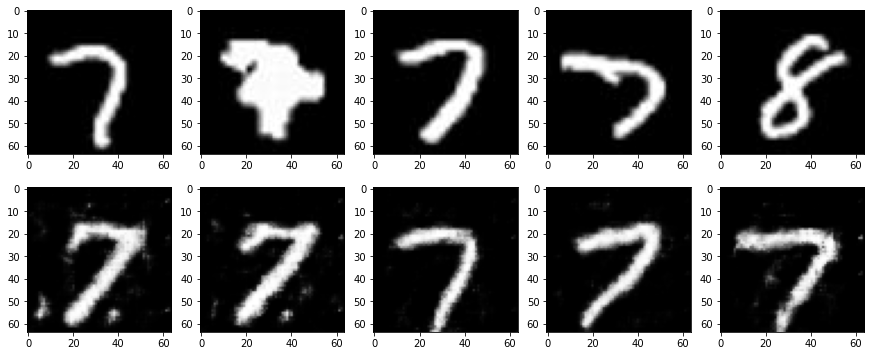

In [34]:
# 생성 화상과 훈련 화상을 시각화한다
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 입력 난수 생성
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다


# 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련 데이터를,
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터를 표시한다
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')


In [35]:
# 테스트용 DataLoader 작성
def make_test_datapath_list():
    """학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트를 작성한다. """

    train_img_list = list()  # 화상 파일 경로를 저장

    for img_idx in range(5):
        img_path = "./data/test_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/test_28size/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


# 파일 리스트를 작성
test_img_list = make_test_datapath_list()

# Dataset 작성
mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform=ImageTransform(mean, std))

# DataLoader 작성
batch_size = 5

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)


In [36]:
# 테스트 데이터 확인
batch_iterator = iter(test_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 훈련 데이터 표시
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')


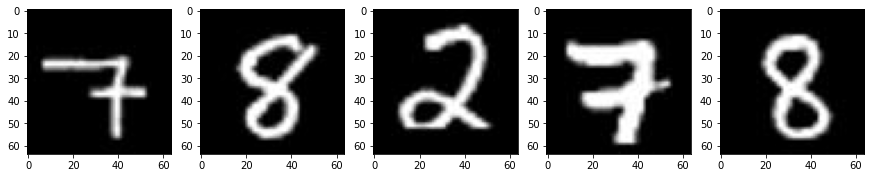

In [37]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1):

    # 테스트 화상 x와 생성 화상 fake_img의 픽셀 수준의 차이의 절대 값을 계산하여, 미니 배치마다 합을 구한다
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    # 테스트 화상 x와 생성 화상 fake_img를 식별기 D에 입력하여, 특징량 맵을 꺼낸다
    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)

    # 테스트 화상 x와 생성 화상 fake_img의 특징량의 차이의 절대값을 계산하여, 미니 배치마다 합을 구한다
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(
        discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    # 미니 배치마다 2종류의 손실을 더한다
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss

    # 미니 배치 전부의 손실을 구한다
    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss


In [ ]:
# 이상 탐지할 화상
x = imges[0:5]
x = x.to(device)

# 지도 데이터의 화상을 Encode하여 z로 한 뒤, G에서 생성
E_update.eval()
G_update.eval()
z_out_real = E_update(imges.to(device))
imges_reconstract = G_update(z_out_real)

# 손실을 구한다
loss, loss_each, residual_loss_each = Anomaly_score(
    x, imges_reconstract, z_out_real, D_update, Lambda=0.1)

# 손실 계산. 총 촌실
loss_each = loss_each.cpu().detach().numpy()
print("total loss: ", np.round(loss_each, 0))

# 화상을 시각화
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련 데이터를,
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터를 표시한다
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(imges_reconstract[i][0].cpu().detach().numpy(), 'gray')
